## Code1 (POO)

In [1]:
import numpy as np
import random

class MCEO_TSP:
    def __init__(self, distance_matrix, n_averages=5, n_search_agents=10, max_iter=100, 
                 alpha=0.2, srf_range=(0.95, 1.05)):
        """
        Initialize the MCEO optimizer for TSP
        
        Parameters:
        - distance_matrix: Symmetric distance matrix between cities
        - n_averages: Number of averages (mean points)
        - n_search_agents: Number of search agents per average
        - max_iter: Maximum number of iterations
        - alpha: Percentage of worst averages to replace with random ones
        - srf_range: Range for Sigma Reduction Factor (min, max)
        """
        self.distance_matrix = distance_matrix
        self.n_cities = distance_matrix.shape[0]
        self.n_averages = n_averages
        self.n_search_agents = n_search_agents
        self.max_iter = max_iter
        self.alpha = alpha
        self.srf_min, self.srf_max = srf_range
        
        # Initialize variables
        self.best_tour = None
        self.best_distance = float('inf')
        self.averages = []  # Will store probability matrices for each average
        self.sigmas = []  # Standard deviations for each average
        
    def initialize(self):
        """Initialize averages and search agents"""
        # Initialize averages uniformly in the search space
        for _ in range(self.n_averages):
            # Create initial probability matrix for each average
            prob_matrix = np.ones((self.n_cities, self.n_cities)) / (self.n_cities - 1)
            np.fill_diagonal(prob_matrix, 0)
            self.averages.append(prob_matrix)
            
            # Initialize standard deviation using Eq. 3 from the paper
            # For TSP, we interpret this as the "spread" of the probability distribution
            initial_sigma = 2 * (1.0 / self.n_averages)  # Simplified version for TSP
            self.sigmas.append(initial_sigma)
    
    def sample_tour(self, prob_matrix):
        """Sample a tour based on edge probabilities"""
        tour = []
        visited = set()
        current = random.randint(0, self.n_cities - 1)
        tour.append(current)
        visited.add(current)
        
        while len(tour) < self.n_cities:
            probs = prob_matrix[current, :].copy()
            for v in visited:
                probs[v] = 0
            if probs.sum() == 0:
                # If all probabilities are zero (shouldn't happen with proper initialization)
                remaining = [c for c in range(self.n_cities) if c not in visited]
                next_city = random.choice(remaining)
            else:
                probs /= probs.sum()
                next_city = np.random.choice(range(self.n_cities), p=probs)
            tour.append(next_city)
            visited.add(next_city)
            current = next_city
        
        return tour
    
    def calculate_tour_distance(self, tour):
        """Calculate total distance of a tour"""
        distance = 0
        for i in range(len(tour)):
            distance += self.distance_matrix[tour[i], tour[(i + 1) % len(tour)]]
        return distance
    
    def update_prob_matrix(self, tours):
        """Update probability matrix based on elite tours"""
        new_prob_matrix = np.zeros((self.n_cities, self.n_cities))
        for tour in tours:
            for i in range(len(tour)):
                u = tour[i]
                v = tour[(i + 1) % self.n_cities]
                new_prob_matrix[u, v] += 1
                new_prob_matrix[v, u] += 1  # Symmetric for undirected TSP
        
        # Normalize
        row_sums = new_prob_matrix.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1  # Avoid division by zero
        new_prob_matrix /= row_sums
        np.fill_diagonal(new_prob_matrix, 0)
        return new_prob_matrix
    
    def optimize(self):
        """Run the MCEO optimization"""
        self.initialize()
        
        for iteration in range(self.max_iter):
            # Step 1: Generate search agents around each average with normal distribution
            all_tours = []
            all_distances = []
            
            for i, (avg, sigma) in enumerate(zip(self.averages, self.sigmas)):
                # Generate search agents around this average
                for _ in range(self.n_search_agents):
                    # Perturb the probability matrix based on sigma
                    perturbed = avg.copy()
                    noise = np.random.normal(0, sigma, size=avg.shape)
                    perturbed += noise
                    perturbed = np.maximum(perturbed, 0)  # Ensure non-negative
                    np.fill_diagonal(perturbed, 0)
                    
                    # Normalize rows
                    row_sums = perturbed.sum(axis=1, keepdims=True)
                    row_sums[row_sums == 0] = 1
                    perturbed /= row_sums
                    
                    # Sample tour and calculate distance
                    tour = self.sample_tour(perturbed)
                    distance = self.calculate_tour_distance(tour)
                    all_tours.append((i, tour, distance))  # Store average index, tour, and distance
                    all_distances.append(distance)
            
            # Step 2: Sort all search agents by distance
            sorted_indices = np.argsort(all_distances)
            sorted_tours = [all_tours[i] for i in sorted_indices]
            
            # Update global best
            if all_distances[sorted_indices[0]] < self.best_distance:
                self.best_distance = all_distances[sorted_indices[0]]
                self.best_tour = sorted_tours[0][1]
                print(f"Iteration {iteration + 1}, Best Distance: {self.best_distance}")
            
            # Step 3: Select new averages from top performers
            new_averages = []
            new_sigmas = []
            
            # Select (1-alpha) best performers as new averages
            n_keep = int(self.n_averages * (1 - self.alpha))
            top_performers = sorted_tours[:n_keep * self.n_search_agents]
            
            # Group by original average index and select best from each group
            avg_groups = {}
            for avg_idx, tour, distance in top_performers:
                if avg_idx not in avg_groups or distance < avg_groups[avg_idx][1]:
                    avg_groups[avg_idx] = (tour, distance)
            
            # Create new probability matrices from the best tours
            for tour, _ in avg_groups.values():
                new_prob = self.update_prob_matrix([tour])
                new_averages.append(new_prob)
            
            # Add alpha random new averages
            for _ in range(self.n_averages - len(new_averages)):
                random_prob = np.ones((self.n_cities, self.n_cities)) / (self.n_cities - 1)
                np.fill_diagonal(random_prob, 0)
                new_averages.append(random_prob)
            
            # Step 4: Update standard deviations using SRF (Sigma Reduction Factor)
            # Calculate SRF for each average based on its rank
            srf_values = np.linspace(self.srf_min, self.srf_max, self.n_averages)
            
            # Update sigmas according to Eq. 4 from the paper
            for i in range(self.n_averages):
                rank_factor = (i + 1) / self.n_averages
                # Simplified version of Eq. 4 for TSP
                new_sigma = (rank_factor ** 3) * (1.0 / (self.n_cities ** 2 / self.n_averages))
                # Apply SRF
                new_sigma *= srf_values[i]
                new_sigmas.append(new_sigma)
            
            self.averages = new_averages
            self.sigmas = new_sigmas
            
            # Early stopping if convergence is detected
            if iteration > 10 and np.std(all_distances[:self.n_averages * self.n_search_agents]) < 1e-3:
                print(f"Converged at iteration {iteration + 1}")
                break
        
        return self.best_tour, self.best_distance

# Example usage
if __name__ == "__main__":
    np.random.seed(42)
    n_cities = 10
    
    # Generate a symmetric distance matrix
    distance_matrix = np.random.randint(10, 100, size=(n_cities, n_cities))
    distance_matrix = (distance_matrix + distance_matrix.T) / 2
    np.fill_diagonal(distance_matrix, 0)
    
    # Run MCEO optimizer
    mceo = MCEO_TSP(distance_matrix, n_averages=5, n_search_agents=10, max_iter=50)
    best_tour, best_distance = mceo.optimize()
    
    print("\nFinal Results:")
    print(f"Best Tour: {best_tour}")
    print(f"Best Distance: {best_distance}")
    print("Distance Matrix:")
    print(distance_matrix)

Iteration 1, Best Distance: 377.5
Iteration 13, Best Distance: 372.5
Iteration 20, Best Distance: 361.0
Iteration 31, Best Distance: 356.0
Iteration 37, Best Distance: 355.5

Final Results:
Best Tour: [1, 2, 3, 8, 6, 7, 9, 5, 4, 0]
Best Distance: 355.5
Distance Matrix:
[[ 0.  28.5 75.  69.5 21.  57.5 76.  48.5 70.5 79.5]
 [28.5  0.  30.5 75.5 35.5 57.5 41.5 55.  17.5 53. ]
 [75.  30.5  0.  54.5 41.5 65.  92.5 65.  74.5 43. ]
 [69.5 75.5 54.5  0.  50.5 59.  80.5 43.5 75.5 85.5]
 [21.  35.5 41.5 50.5  0.  29.5 36.  56.  97.  69. ]
 [57.5 57.5 65.  59.  29.5  0.  64.  66.5 62.  33.5]
 [76.  41.5 92.5 80.5 36.  64.   0.  27.  32.  50.5]
 [48.5 55.  65.  43.5 56.  66.5 27.   0.  82.5 23.5]
 [70.5 17.5 74.5 75.5 97.  62.  32.  82.5  0.  72.5]
 [79.5 53.  43.  85.5 69.  33.5 50.5 23.5 72.5  0. ]]


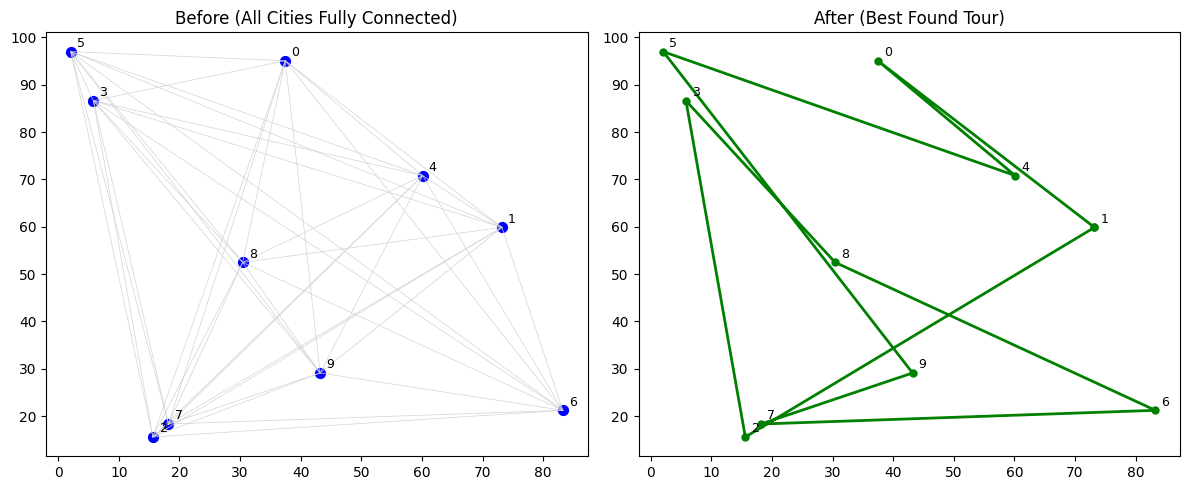

In [2]:
import matplotlib.pyplot as plt

def generate_coordinates(n, seed=0):
    """Generate random 2D coordinates for cities"""
    np.random.seed(seed)
    return np.random.rand(n, 2) * 100

def plot_tours(coords, best_tour):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot before: all cities and all possible connections (fully connected)
    axes[0].set_title("Before (All Cities Fully Connected)")
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            axes[0].plot([coords[i][0], coords[j][0]], [coords[i][1], coords[j][1]], color='lightgray', linewidth=0.5)
    axes[0].scatter(coords[:, 0], coords[:, 1], color='blue', s=50)
    for idx, (x, y) in enumerate(coords):
        axes[0].text(x + 1, y + 1, str(idx), fontsize=9)

    # Plot after: best tour path
    axes[1].set_title("After (Best Found Tour)")
    tour_coords = coords[best_tour + [best_tour[0]]]  # close the tour
    axes[1].plot(tour_coords[:, 0], tour_coords[:, 1], 'o-', color='green', linewidth=2, markersize=5)
    for idx in best_tour:
        x, y = coords[idx]
        axes[1].text(x + 1, y + 1, str(idx), fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Coordinates for visualization
coordinates = generate_coordinates(n_cities, seed=42)
plot_tours(coordinates, best_tour)


## Code2 (No POO)

Iteration 1, Best Distance: 451.00
Iteration 3, Best Distance: 447.00
Iteration 4, Best Distance: 439.00
Iteration 5, Best Distance: 387.50
Iteration 10, Best Distance: 381.50
Iteration 12, Best Distance: 338.00
Iteration 27, Best Distance: 330.00

Final Best Tour: [7, 6, 8, 1, 0, 4, 5, 9, 2, 3]
Final Best Distance: 330.0


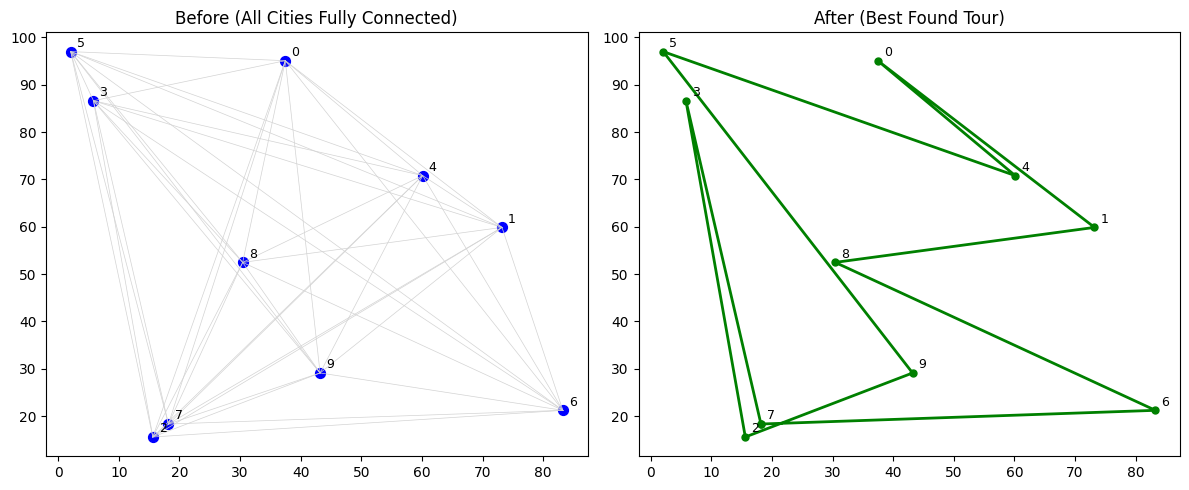

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

def initialize(n_cities, n_averages):
    averages = []
    sigmas = []
    for _ in range(n_averages):
        prob_matrix = np.ones((n_cities, n_cities)) / (n_cities - 1)
        np.fill_diagonal(prob_matrix, 0)
        averages.append(prob_matrix)
        sigma = 2 * (1.0 / n_averages)
        sigmas.append(sigma)
    return averages, sigmas

def sample_tour(prob_matrix):
    n_cities = prob_matrix.shape[0]
    tour = []
    visited = set()
    current = random.randint(0, n_cities - 1)
    tour.append(current)
    visited.add(current)

    while len(tour) < n_cities:
        probs = prob_matrix[current, :].copy()
        for v in visited:
            probs[v] = 0
        if probs.sum() == 0:
            remaining = [c for c in range(n_cities) if c not in visited]
            next_city = random.choice(remaining)
        else:
            probs /= probs.sum()
            next_city = np.random.choice(range(n_cities), p=probs)
        tour.append(next_city)
        visited.add(next_city)
        current = next_city

    return tour

def calculate_distance(tour, distance_matrix):
    return sum(distance_matrix[tour[i], tour[(i + 1) % len(tour)]] for i in range(len(tour)))

def update_prob_matrix(tours, n_cities):
    prob_matrix = np.zeros((n_cities, n_cities))
    for tour in tours:
        for i in range(len(tour)):
            u, v = tour[i], tour[(i + 1) % n_cities]
            prob_matrix[u, v] += 1
            prob_matrix[v, u] += 1
    row_sums = prob_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    prob_matrix /= row_sums
    np.fill_diagonal(prob_matrix, 0)
    return prob_matrix

def optimize_mceo(distance_matrix, n_averages=5, n_search_agents=10, max_iter=100, alpha=0.2, srf_range=(0.95, 1.05)):
    n_cities = distance_matrix.shape[0]
    srf_min, srf_max = srf_range
    averages, sigmas = initialize(n_cities, n_averages)

    best_tour = None
    best_distance = float('inf')

    for iteration in range(max_iter):
        all_tours = []
        all_distances = []
        avg_indices = []

        for i, (avg, sigma) in enumerate(zip(averages, sigmas)):
            for _ in range(n_search_agents):
                noise = np.random.normal(0, sigma, size=avg.shape)
                perturbed = avg + noise
                perturbed = np.maximum(perturbed, 0)
                np.fill_diagonal(perturbed, 0)
                row_sums = perturbed.sum(axis=1, keepdims=True)
                row_sums[row_sums == 0] = 1
                perturbed /= row_sums

                tour = sample_tour(perturbed)
                dist = calculate_distance(tour, distance_matrix)
                all_tours.append((i, tour, dist))
                all_distances.append(dist)

        sorted_indices = np.argsort(all_distances)
        sorted_tours = [all_tours[i] for i in sorted_indices]

        if all_distances[sorted_indices[0]] < best_distance:
            best_distance = all_distances[sorted_indices[0]]
            best_tour = sorted_tours[0][1]
            print(f"Iteration {iteration + 1}, Best Distance: {best_distance:.2f}")

        # Select top performers
        n_keep = int(n_averages * (1 - alpha))
        top_performers = sorted_tours[:n_keep * n_search_agents]

        avg_groups = {}
        for avg_idx, tour, dist in top_performers:
            if avg_idx not in avg_groups or dist < avg_groups[avg_idx][1]:
                avg_groups[avg_idx] = (tour, dist)

        new_averages = [update_prob_matrix([tour], n_cities) for tour, _ in avg_groups.values()]
        for _ in range(n_averages - len(new_averages)):
            prob_matrix = np.ones((n_cities, n_cities)) / (n_cities - 1)
            np.fill_diagonal(prob_matrix, 0)
            new_averages.append(prob_matrix)

        srf_values = np.linspace(srf_min, srf_max, n_averages)
        new_sigmas = []
        for i in range(n_averages):
            rank_factor = (i + 1) / n_averages
            sigma = (rank_factor ** 3) * (1.0 / (n_cities ** 2 / n_averages))
            sigma *= srf_values[i]
            new_sigmas.append(sigma)

        averages, sigmas = new_averages, new_sigmas

        if iteration > 10 and np.std(all_distances[:n_averages * n_search_agents]) < 1e-3:
            print(f"Converged at iteration {iteration + 1}")
            break

    return best_tour, best_distance

# === Visualization Helpers ===

def generate_coordinates(n, seed=0):
    np.random.seed(seed)
    return np.random.rand(n, 2) * 100

def plot_tours(coords, best_tour):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Before
    axes[0].set_title("Before (All Cities Fully Connected)")
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            axes[0].plot([coords[i][0], coords[j][0]], [coords[i][1], coords[j][1]], color='lightgray', linewidth=0.5)
    axes[0].scatter(coords[:, 0], coords[:, 1], color='blue', s=50)
    for idx, (x, y) in enumerate(coords):
        axes[0].text(x + 1, y + 1, str(idx), fontsize=9)

    # After
    axes[1].set_title("After (Best Found Tour)")
    tour_coords = coords[best_tour + [best_tour[0]]]
    axes[1].plot(tour_coords[:, 0], tour_coords[:, 1], 'o-', color='green', linewidth=2, markersize=5)
    for idx in best_tour:
        x, y = coords[idx]
        axes[1].text(x + 1, y + 1, str(idx), fontsize=9)

    plt.tight_layout()
    plt.show()

# === Main Execution ===

if __name__ == "__main__":
    np.random.seed(42)
    n_cities = 10
    distance_matrix = np.random.randint(10, 100, size=(n_cities, n_cities))
    distance_matrix = (distance_matrix + distance_matrix.T) / 2
    np.fill_diagonal(distance_matrix, 0)

    best_tour, best_distance = optimize_mceo(distance_matrix, max_iter=50)
    print("\nFinal Best Tour:", best_tour)
    print("Final Best Distance:", best_distance)

    coords = generate_coordinates(n_cities, seed=42)
    plot_tours(coords, best_tour)


## Utilisation des villes réelles

In [1]:
import numpy as np
import random
import plotly.graph_objects as go

# --- Données réelles : villes marocaines ---
cities = [
    ("Tanger", 35.7595, -5.8339),
    ("Tétouan", 35.5785, -5.3684),
    ("Fès", 34.0331, -5.0003),
    ("Rabat", 34.0209, -6.8417),
    ("Casablanca", 33.5731, -7.5898),
    ("Marrakech", 31.6295, -7.9811),
    ("Agadir", 30.4278, -9.5981),
    ("Oujda", 34.6833, -1.9167),
    ("Meknès", 33.8935, -5.5473),
    ("Laâyoune", 27.1536, -13.2033)
]

# --- Haversine ---
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def compute_distance_matrix(cities):
    n = len(cities)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i][j] = haversine_distance(
                    cities[i][1], cities[i][2],
                    cities[j][1], cities[j][2]
                )
    return dist_matrix

def get_city_coordinates_3d(cities):
    return np.array([[lon * 100, lat * 100, 0] for (_, lat, lon) in cities])

# --- MCEO TSP Core ---
def initialize(n_cities, n_averages):
    averages, sigmas = [], []
    for _ in range(n_averages):
        prob_matrix = np.ones((n_cities, n_cities)) / (n_cities - 1)
        np.fill_diagonal(prob_matrix, 0)
        averages.append(prob_matrix)
        sigmas.append(2 * (1.0 / n_averages))
    return averages, sigmas

def sample_tour(prob_matrix):
    n_cities = prob_matrix.shape[0]
    tour, visited = [], set()
    current = random.randint(0, n_cities - 1)
    tour.append(current)
    visited.add(current)

    while len(tour) < n_cities:
        probs = prob_matrix[current].copy()
        for v in visited:
            probs[v] = 0
        if probs.sum() == 0:
            next_city = random.choice([c for c in range(n_cities) if c not in visited])
        else:
            probs /= probs.sum()
            next_city = np.random.choice(range(n_cities), p=probs)
        tour.append(next_city)
        visited.add(next_city)
        current = next_city

    return tour

def calculate_distance(tour, distance_matrix):
    return sum(distance_matrix[tour[i], tour[(i + 1) % len(tour)]] for i in range(len(tour)))

def update_prob_matrix(tours, n_cities):
    prob_matrix = np.zeros((n_cities, n_cities))
    for tour in tours:
        for i in range(len(tour)):
            u, v = tour[i], tour[(i + 1) % len(tour)]
            prob_matrix[u, v] += 1
            prob_matrix[v, u] += 1
    row_sums = prob_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    prob_matrix /= row_sums
    np.fill_diagonal(prob_matrix, 0)
    return prob_matrix

def optimize_mceo(distance_matrix, n_averages=5, n_search_agents=10, max_iter=100, alpha=0.2, srf_range=(0.95, 1.05)):
    n_cities = distance_matrix.shape[0]
    srf_min, srf_max = srf_range
    averages, sigmas = initialize(n_cities, n_averages)
    best_tour, best_distance = None, float('inf')

    for iteration in range(max_iter):
        all_tours, all_distances = [], []

        for i, (avg, sigma) in enumerate(zip(averages, sigmas)):
            for _ in range(n_search_agents):
                perturbed = avg + np.random.normal(0, sigma, size=avg.shape)
                perturbed = np.maximum(perturbed, 0)
                np.fill_diagonal(perturbed, 0)
                perturbed /= np.sum(perturbed, axis=1, keepdims=True, where=perturbed.sum(axis=1, keepdims=True)!=0)

                tour = sample_tour(perturbed)
                dist = calculate_distance(tour, distance_matrix)
                all_tours.append((i, tour, dist))
                all_distances.append(dist)

        sorted_indices = np.argsort(all_distances)
        sorted_tours = [all_tours[i] for i in sorted_indices]

        if all_distances[sorted_indices[0]] < best_distance:
            best_distance = all_distances[sorted_indices[0]]
            best_tour = sorted_tours[0][1]
            print(f"Iteration {iteration + 1}, Best Distance: {best_distance:.2f} km")

        # Top performers
        n_keep = int(n_averages * (1 - alpha))
        top_performers = sorted_tours[:n_keep * n_search_agents]
        avg_groups = {}
        for avg_idx, tour, dist in top_performers:
            if avg_idx not in avg_groups or dist < avg_groups[avg_idx][1]:
                avg_groups[avg_idx] = (tour, dist)

        new_averages = [update_prob_matrix([tour], n_cities) for tour, _ in avg_groups.values()]
        for _ in range(n_averages - len(new_averages)):
            prob_matrix = np.ones((n_cities, n_cities)) / (n_cities - 1)
            np.fill_diagonal(prob_matrix, 0)
            new_averages.append(prob_matrix)

        srf_values = np.linspace(srf_min, srf_max, n_averages)
        new_sigmas = []
        for i in range(n_averages):
            rank_factor = (i + 1) / n_averages
            sigma = (rank_factor ** 3) * (1.0 / (n_cities ** 2 / n_averages))
            sigma *= srf_values[i]
            new_sigmas.append(sigma)

        averages, sigmas = new_averages, new_sigmas

        if iteration > 10 and np.std(all_distances[:n_averages * n_search_agents]) < 1e-3:
            print(f"Converged at iteration {iteration + 1}")
            break

    return best_tour, best_distance

# --- 3D Visualization ---
def plot_tours_3d(coords, best_tour, city_names):
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

    def make_edges(tour, color='lightgray', width=2):
        edge_x, edge_y, edge_z = [], [], []
        for i in range(len(tour)):
            u, v = tour[i], tour[(i + 1) % len(tour)]
            edge_x += [coords[u][0], coords[v][0], None]
            edge_y += [coords[u][1], coords[v][1], None]
            edge_z += [coords[u][2], coords[v][2], None]
        return go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines',
                            line=dict(color=color, width=width), showlegend=False)

    fig = go.Figure()
    fig.add_trace(make_edges(best_tour, color='green', width=4))

    fig.add_trace(go.Scatter3d(
        x=x, y=y, z=z, mode='markers+text',
        text=city_names,
        marker=dict(size=6, color='blue'),
        textposition='top center'
    ))

    fig.update_layout(
        title="Tournée Optimale des Villes Marocaines - Visualisation 3D",
        scene=dict(xaxis=dict(title='Longitude*100'), yaxis=dict(title='Latitude*100'), zaxis=dict(title=''),
                   aspectmode='cube'),
        margin=dict(l=0, r=0, b=0, t=30),
        showlegend=False
    )
    fig.show()

# --- Main ---
if __name__ == "__main__":
    np.random.seed(42)
    distance_matrix = compute_distance_matrix(cities)
    coords = get_city_coordinates_3d(cities)
    city_names = [name for name, _, _ in cities]

    best_tour, best_distance = optimize_mceo(distance_matrix, max_iter=50)

    print("\n🏁 Meilleur chemin trouvé :")
    for i in best_tour:
        print(f"- {city_names[i]}")
    print(f"🔁 Distance totale : {best_distance:.2f} km")

    plot_tours_3d(coords, best_tour, city_names)

Iteration 1, Best Distance: 4086.96 km
Iteration 2, Best Distance: 3644.64 km
Iteration 3, Best Distance: 3399.47 km
Iteration 6, Best Distance: 3365.87 km
Iteration 8, Best Distance: 3306.79 km
Iteration 9, Best Distance: 3306.79 km
Iteration 10, Best Distance: 3300.66 km
Iteration 11, Best Distance: 3097.22 km
Iteration 15, Best Distance: 3077.90 km
Iteration 16, Best Distance: 3077.90 km
Iteration 36, Best Distance: 2963.04 km
Iteration 37, Best Distance: 2963.04 km

🏁 Meilleur chemin trouvé :
- Casablanca
- Laâyoune
- Agadir
- Marrakech
- Meknès
- Fès
- Oujda
- Tétouan
- Tanger
- Rabat
🔁 Distance totale : 2963.04 km


Iteration 1, Best Distance: 3360.42 km
Iteration 2, Best Distance: 3226.15 km
Iteration 3, Best Distance: 3226.15 km
Iteration 6, Best Distance: 3178.59 km
Iteration 7, Best Distance: 3178.59 km
Iteration 8, Best Distance: 3178.59 km
Iteration 16, Best Distance: 3175.81 km
Iteration 17, Best Distance: 3157.15 km
Iteration 19, Best Distance: 3157.15 km
Iteration 20, Best Distance: 3026.56 km
Iteration 21, Best Distance: 3026.56 km
Iteration 31, Best Distance: 3023.80 km
Iteration 32, Best Distance: 3023.80 km
Iteration 37, Best Distance: 3014.38 km
Iteration 38, Best Distance: 3014.38 km
Iteration 39, Best Distance: 2996.66 km
Iteration 40, Best Distance: 2996.66 km
Iteration 43, Best Distance: 2996.66 km
Iteration 49, Best Distance: 2963.04 km
Iteration 50, Best Distance: 2963.04 km

🏁 Meilleur chemin trouvé :
- Tétouan
- Tanger
- Rabat
- Casablanca
- Laâyoune
- Agadir
- Marrakech
- Meknès
- Fès
- Oujda
🔁 Distance totale : 2963.04 km


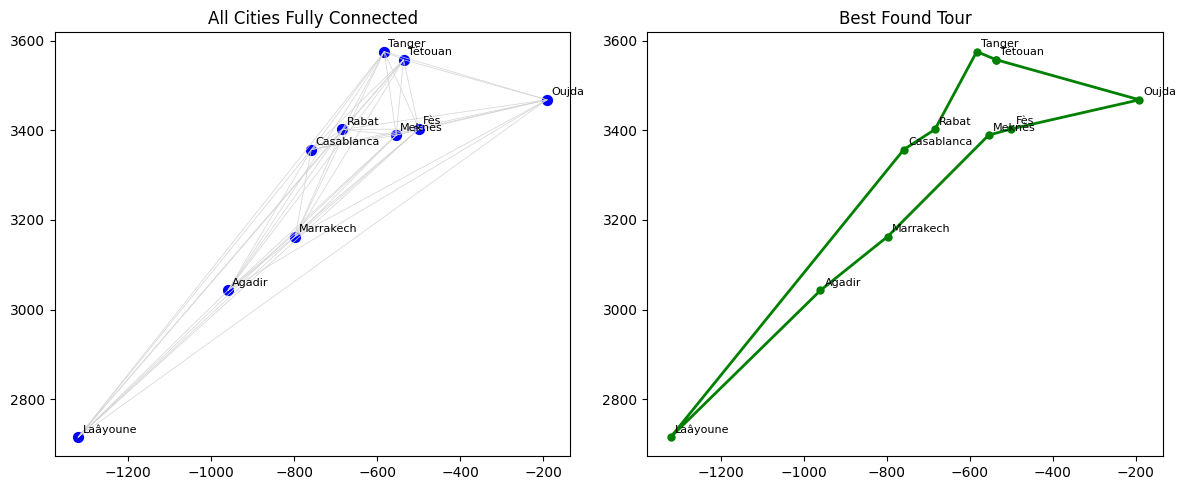

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

# --- Données réelles : villes marocaines ---
cities = [
    ("Tanger", 35.7595, -5.8339),
    ("Tétouan", 35.5785, -5.3684),
    ("Fès", 34.0331, -5.0003),
    ("Rabat", 34.0209, -6.8417),
    ("Casablanca", 33.5731, -7.5898),
    ("Marrakech", 31.6295, -7.9811),
    ("Agadir", 30.4278, -9.5981),
    ("Oujda", 34.6833, -1.9167),
    ("Meknès", 33.8935, -5.5473),
    ("Laâyoune", 27.1536, -13.2033)
]

# --- Haversine ---
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def compute_distance_matrix(cities):
    n = len(cities)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i][j] = haversine_distance(
                    cities[i][1], cities[i][2],
                    cities[j][1], cities[j][2]
                )
    return dist_matrix

def get_city_coordinates_3d(cities):
    return np.array([[lon * 100, lat * 100, 0] for (_, lat, lon) in cities])

# --- MCEO TSP Core ---
def initialize(n_cities, n_averages):
    averages, sigmas = [], []
    for _ in range(n_averages):
        prob_matrix = np.ones((n_cities, n_cities)) / (n_cities - 1)
        np.fill_diagonal(prob_matrix, 0)
        averages.append(prob_matrix)
        sigmas.append(2 * (1.0 / n_averages))
    return averages, sigmas

def sample_tour(prob_matrix):
    n_cities = prob_matrix.shape[0]
    tour, visited = [], set()
    current = random.randint(0, n_cities - 1)
    tour.append(current)
    visited.add(current)

    while len(tour) < n_cities:
        probs = prob_matrix[current].copy()
        for v in visited:
            probs[v] = 0
        if probs.sum() == 0:
            next_city = random.choice([c for c in range(n_cities) if c not in visited])
        else:
            probs /= probs.sum()
            next_city = np.random.choice(range(n_cities), p=probs)
        tour.append(next_city)
        visited.add(next_city)
        current = next_city

    return tour

def calculate_distance(tour, distance_matrix):
    return sum(distance_matrix[tour[i], tour[(i + 1) % len(tour)]] for i in range(len(tour)))

def update_prob_matrix(tours, n_cities):
    prob_matrix = np.zeros((n_cities, n_cities))
    for tour in tours:
        for i in range(len(tour)):
            u, v = tour[i], tour[(i + 1) % len(tour)]
            prob_matrix[u, v] += 1
            prob_matrix[v, u] += 1
    row_sums = prob_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    prob_matrix /= row_sums
    np.fill_diagonal(prob_matrix, 0)
    return prob_matrix

def optimize_mceo(distance_matrix, n_averages=5, n_search_agents=10, max_iter=100, alpha=0.2, srf_range=(0.95, 1.05)):
    n_cities = distance_matrix.shape[0]
    srf_min, srf_max = srf_range
    averages, sigmas = initialize(n_cities, n_averages)
    best_tour, best_distance = None, float('inf')

    for iteration in range(max_iter):
        all_tours, all_distances = [], []

        for i, (avg, sigma) in enumerate(zip(averages, sigmas)):
            for _ in range(n_search_agents):
                perturbed = avg + np.random.normal(0, sigma, size=avg.shape)
                perturbed = np.maximum(perturbed, 0)
                np.fill_diagonal(perturbed, 0)
                row_sums = np.sum(perturbed, axis=1, keepdims=True)
                row_sums[row_sums == 0] = 1
                perturbed /= row_sums

                tour = sample_tour(perturbed)
                dist = calculate_distance(tour, distance_matrix)
                all_tours.append((i, tour, dist))
                all_distances.append(dist)

        sorted_indices = np.argsort(all_distances)
        sorted_tours = [all_tours[i] for i in sorted_indices]

        if all_distances[sorted_indices[0]] < best_distance:
            best_distance = all_distances[sorted_indices[0]]
            best_tour = sorted_tours[0][1]
            print(f"Iteration {iteration + 1}, Best Distance: {best_distance:.2f} km")

        # Top performers
        n_keep = int(n_averages * (1 - alpha))
        top_performers = sorted_tours[:n_keep * n_search_agents]
        avg_groups = {}
        for avg_idx, tour, dist in top_performers:
            if avg_idx not in avg_groups or dist < avg_groups[avg_idx][1]:
                avg_groups[avg_idx] = (tour, dist)

        new_averages = [update_prob_matrix([tour], n_cities) for tour, _ in avg_groups.values()]
        for _ in range(n_averages - len(new_averages)):
            prob_matrix = np.ones((n_cities, n_cities)) / (n_cities - 1)
            np.fill_diagonal(prob_matrix, 0)
            new_averages.append(prob_matrix)

        srf_values = np.linspace(srf_min, srf_max, n_averages)
        new_sigmas = []
        for i in range(n_averages):
            rank_factor = (i + 1) / n_averages
            sigma = (rank_factor ** 3) * (1.0 / (n_cities ** 2 / n_averages))
            sigma *= srf_values[i]
            new_sigmas.append(sigma)

        averages, sigmas = new_averages, new_sigmas

        if iteration > 10 and np.std(all_distances[:n_averages * n_search_agents]) < 1e-3:
            print(f"Converged at iteration {iteration + 1}")
            break

    return best_tour, best_distance

# --- 3D Visualization ---
def plot_tours(coords, best_tour, city_names):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Before
    axes[0].set_title("All Cities Fully Connected")
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            axes[0].plot([coords[i][0], coords[j][0]], [coords[i][1], coords[j][1]], color='lightgray', linewidth=0.5)
    axes[0].scatter(coords[:, 0], coords[:, 1], color='blue', s=50)
    for idx, (x, y, _) in enumerate(coords):
        axes[0].text(x + 10, y + 10, city_names[idx], fontsize=8, color='black')  # Added city names

    # After
    axes[1].set_title("Best Found Tour")
    tour_coords = coords[np.append(best_tour, best_tour[0])]
    axes[1].plot(tour_coords[:, 0], tour_coords[:, 1], 'o-', color='green', linewidth=2, markersize=5)
    for idx in best_tour:
        x, y, _ = coords[idx]
        axes[1].text(x + 10, y + 10, city_names[idx], fontsize=8, color='black')  # Added city names

    plt.tight_layout()
    plt.show()

# --- Main ---
if __name__ == "__main__":
    np.random.seed(42)
    distance_matrix = compute_distance_matrix(cities)
    coords = get_city_coordinates_3d(cities)
    city_names = [name for name, _, _ in cities]

    best_tour, best_distance = optimize_mceo(distance_matrix, max_iter=100)

    print("\n🏁 Meilleur chemin trouvé :")
    for i in best_tour:
        print(f"- {city_names[i]}")
    print(f"🔁 Distance totale : {best_distance:.2f} km")

    plot_tours(coords, best_tour, city_names)

Iteration 1, Best Distance: 3584.82 km
Iteration 3, Best Distance: 3577.00 km
Iteration 4, Best Distance: 3421.50 km
Iteration 5, Best Distance: 3254.81 km
Iteration 8, Best Distance: 3072.17 km

🏁 Meilleur chemin trouvé :
- Oujda
- Tétouan
- Tanger
- Meknès
- Rabat
- Casablanca
- Laâyoune
- Agadir
- Marrakech
- Fès
🔁 Distance totale : 3072.17 km


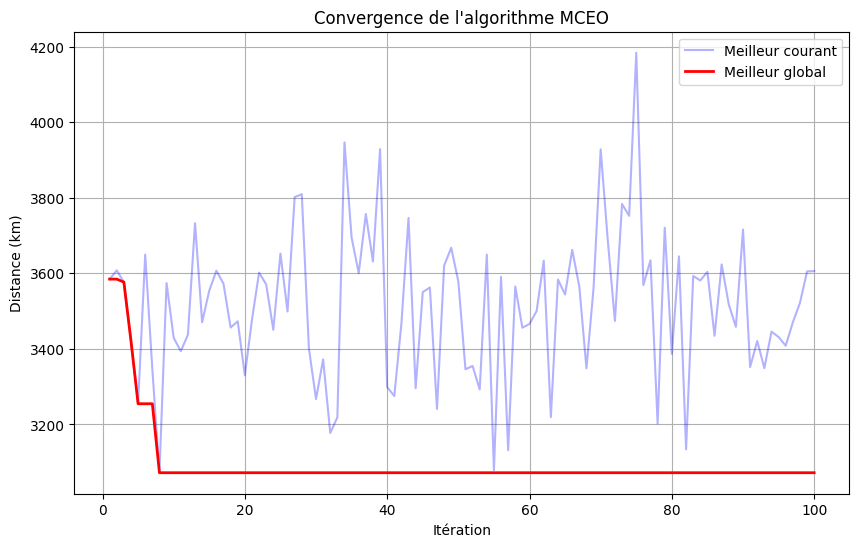

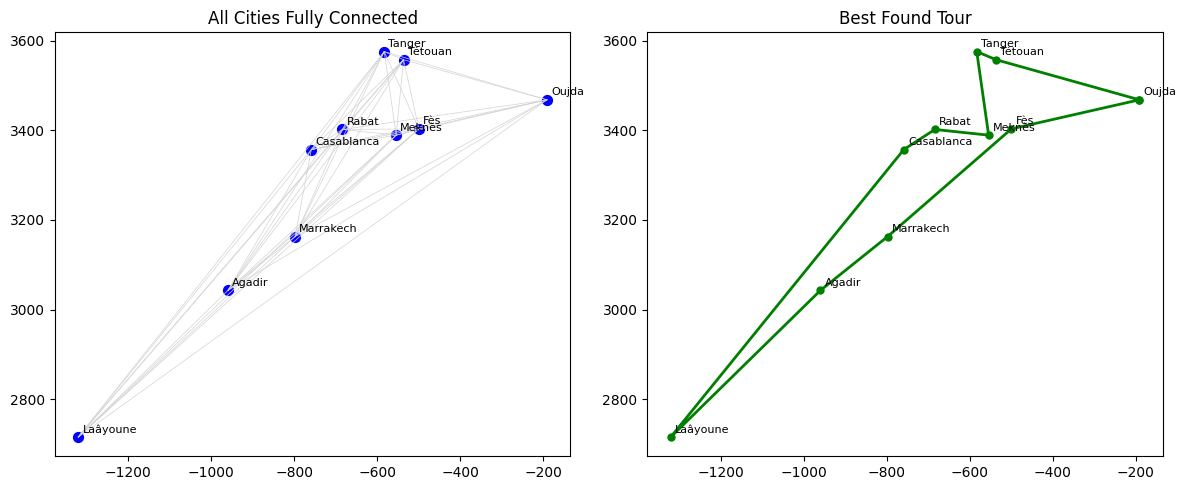

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# --- Données réelles : villes marocaines ---
cities = [
    ("Tanger", 35.7595, -5.8339),
    ("Tétouan", 35.5785, -5.3684),
    ("Fès", 34.0331, -5.0003),
    ("Rabat", 34.0209, -6.8417),
    ("Casablanca", 33.5731, -7.5898),
    ("Marrakech", 31.6295, -7.9811),
    ("Agadir", 30.4278, -9.5981),
    ("Oujda", 34.6833, -1.9167),
    ("Meknès", 33.8935, -5.5473),
    ("Laâyoune", 27.1536, -13.2033)
]

# --- Haversine ---
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def compute_distance_matrix(cities):
    n = len(cities)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i][j] = haversine_distance(
                    cities[i][1], cities[i][2],
                    cities[j][1], cities[j][2]
                )
    return dist_matrix

def get_city_coordinates_3d(cities):
    return np.array([[lon * 100, lat * 100, 0] for (_, lat, lon) in cities])

# --- MCEO TSP Core ---
def initialize(n_cities, n_averages):
    averages, sigmas = [], []
    for _ in range(n_averages):
        prob_matrix = np.ones((n_cities, n_cities)) / (n_cities - 1)
        np.fill_diagonal(prob_matrix, 0)
        averages.append(prob_matrix)
        sigmas.append(2 * (1.0 / n_averages))
    return averages, sigmas

def sample_tour(prob_matrix):
    n_cities = prob_matrix.shape[0]
    tour, visited = [], set()
    current = random.randint(0, n_cities - 1)
    tour.append(current)
    visited.add(current)

    while len(tour) < n_cities:
        probs = prob_matrix[current].copy()
        for v in visited:
            probs[v] = 0
        if probs.sum() == 0:
            next_city = random.choice([c for c in range(n_cities) if c not in visited])
        else:
            probs /= probs.sum()
            next_city = np.random.choice(range(n_cities), p=probs)
        tour.append(next_city)
        visited.add(next_city)
        current = next_city

    return tour

def calculate_distance(tour, distance_matrix):
    return sum(distance_matrix[tour[i], tour[(i + 1) % len(tour)]] for i in range(len(tour)))

def update_prob_matrix(tours, n_cities):
    prob_matrix = np.zeros((n_cities, n_cities))
    for tour in tours:
        for i in range(len(tour)):
            u, v = tour[i], tour[(i + 1) % len(tour)]
            prob_matrix[u, v] += 1
            prob_matrix[v, u] += 1
    row_sums = prob_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    prob_matrix /= row_sums
    np.fill_diagonal(prob_matrix, 0)
    return prob_matrix

def optimize_mceo(distance_matrix, n_averages=5, n_search_agents=10, max_iter=100, alpha=0.2, srf_range=(0.95, 1.05)):
    n_cities = distance_matrix.shape[0]
    srf_min, srf_max = srf_range
    averages, sigmas = initialize(n_cities, n_averages)
    best_tour, best_distance = None, float('inf')

    for iteration in range(max_iter):
        all_tours, all_distances = [], []

        for i, (avg, sigma) in enumerate(zip(averages, sigmas)):
            for _ in range(n_search_agents):
                perturbed = avg + np.random.normal(0, sigma, size=avg.shape)
                perturbed = np.maximum(perturbed, 0)
                np.fill_diagonal(perturbed, 0)
                row_sums = np.sum(perturbed, axis=1, keepdims=True)
                row_sums[row_sums == 0] = 1
                perturbed /= row_sums

                tour = sample_tour(perturbed)
                dist = calculate_distance(tour, distance_matrix)
                all_tours.append((i, tour, dist))
                all_distances.append(dist)

        sorted_indices = np.argsort(all_distances)
        sorted_tours = [all_tours[i] for i in sorted_indices]

        if all_distances[sorted_indices[0]] < best_distance:
            best_distance = all_distances[sorted_indices[0]]
            best_tour = sorted_tours[0][1]
            print(f"Iteration {iteration + 1}, Best Distance: {best_distance:.2f} km")

        # Top performers
        n_keep = int(n_averages * (1 - alpha))
        top_performers = sorted_tours[:n_keep * n_search_agents]
        avg_groups = {}
        for avg_idx, tour, dist in top_performers:
            if avg_idx not in avg_groups or dist < avg_groups[avg_idx][1]:
                avg_groups[avg_idx] = (tour, dist)

        new_averages = [update_prob_matrix([tour], n_cities) for tour, _ in avg_groups.values()]
        for _ in range(n_averages - len(new_averages)):
            prob_matrix = np.ones((n_cities, n_cities)) / (n_cities - 1)
            np.fill_diagonal(prob_matrix, 0)
            new_averages.append(prob_matrix)

        srf_values = np.linspace(srf_min, srf_max, n_averages)
        new_sigmas = []
        for i in range(n_averages):
            rank_factor = (i + 1) / n_averages
            sigma = (rank_factor ** 3) * (1.0 / (n_cities ** 2 / n_averages))
            sigma *= srf_values[i]
            new_sigmas.append(sigma)

        averages, sigmas = new_averages, new_sigmas

        if iteration > 10 and np.std(all_distances[:n_averages * n_search_agents]) < 1e-3:
            print(f"Converged at iteration {iteration + 1}")
            break

    return best_tour, best_distance

# --- 3D Visualization ---
def plot_tours(coords, best_tour, city_names):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Before
    axes[0].set_title("All Cities Fully Connected")
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            axes[0].plot([coords[i][0], coords[j][0]], [coords[i][1], coords[j][1]], color='lightgray', linewidth=0.5)
    axes[0].scatter(coords[:, 0], coords[:, 1], color='blue', s=50)
    for idx, (x, y, _) in enumerate(coords):
        axes[0].text(x + 10, y + 10, city_names[idx], fontsize=8, color='black')  # Added city names

    # After
    axes[1].set_title("Best Found Tour")
    tour_coords = coords[np.append(best_tour, best_tour[0])]
    axes[1].plot(tour_coords[:, 0], tour_coords[:, 1], 'o-', color='green', linewidth=2, markersize=5)
    for idx in best_tour:
        x, y, _ = coords[idx]
        axes[1].text(x + 10, y + 10, city_names[idx], fontsize=8, color='black')  # Added city names

    plt.tight_layout()
    plt.show()

def optimize_mceo(distance_matrix, n_averages=5, n_search_agents=10, max_iter=100, alpha=0.2, srf_range=(0.95, 1.05)):
    n_cities = distance_matrix.shape[0]
    srf_min, srf_max = srf_range
    averages, sigmas = initialize(n_cities, n_averages)
    best_tour, best_distance = None, float('inf')
    
    # Ajout pour stocker l'historique
    iteration_history = []
    best_history = []
    current_history = []

    for iteration in range(max_iter):
        all_tours, all_distances = [], []

        for i, (avg, sigma) in enumerate(zip(averages, sigmas)):
            for _ in range(n_search_agents):
                perturbed = avg + np.random.normal(0, sigma, size=avg.shape)
                perturbed = np.maximum(perturbed, 0)
                np.fill_diagonal(perturbed, 0)
                row_sums = np.sum(perturbed, axis=1, keepdims=True)
                row_sums[row_sums == 0] = 1
                perturbed /= row_sums

                tour = sample_tour(perturbed)
                dist = calculate_distance(tour, distance_matrix)
                all_tours.append((i, tour, dist))
                all_distances.append(dist)

        sorted_indices = np.argsort(all_distances)
        sorted_tours = [all_tours[i] for i in sorted_indices]

        # Mise à jour de l'historique
        current_best = all_distances[sorted_indices[0]]
        iteration_history.append(iteration+1)
        current_history.append(current_best)
        
        if current_best < best_distance:
            best_distance = current_best
            best_tour = sorted_tours[0][1]
            print(f"Iteration {iteration + 1}, Best Distance: {best_distance:.2f} km")
        best_history.append(best_distance)

        # [Le reste de la fonction reste inchangé...]

    return best_tour, best_distance, iteration_history, current_history, best_history

# Nouvelle fonction pour tracer la convergence
def plot_convergence(iteration_history, current_history, best_history):
    plt.figure(figsize=(10, 6))
    plt.plot(iteration_history, current_history, 'b-', alpha=0.3, label='Meilleur courant')
    plt.plot(iteration_history, best_history, 'r-', linewidth=2, label='Meilleur global')
    plt.xlabel('Itération')
    plt.ylabel('Distance (km)')
    plt.title('Convergence de l\'algorithme MCEO')
    plt.legend()
    plt.grid(True)
    plt.show()


# --- Main ---
if __name__ == "__main__":
    np.random.seed(42)
    distance_matrix = compute_distance_matrix(cities)
    coords = get_city_coordinates_3d(cities)
    city_names = [name for name, _, _ in cities]

    best_tour, best_distance, iterations, current, best = optimize_mceo(distance_matrix, max_iter=100)

    print("\n🏁 Meilleur chemin trouvé :")
    for i in best_tour:
        print(f"- {city_names[i]}")
    print(f"🔁 Distance totale : {best_distance:.2f} km")

    # Tracer la convergence
    plot_convergence(iterations, current, best)
    
    # Tracer les tours comme avant
    plot_tours(coords, best_tour, city_names)

Iteration 1, Best Distance: 3443.86 km
Iteration 2, Best Distance: 3415.60 km
Iteration 7, Best Distance: 3037.57 km

🏁 Meilleur chemin trouvé :
- Tanger
- Casablanca
- Marrakech
- Agadir
- Laâyoune
- Rabat
- Meknès
- Fès
- Oujda
- Tétouan
🔁 Distance totale : 3037.57 km


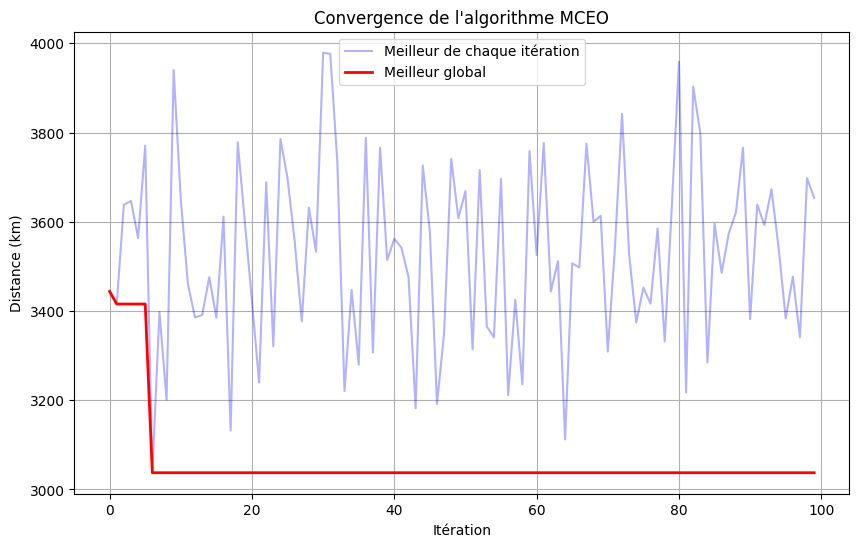

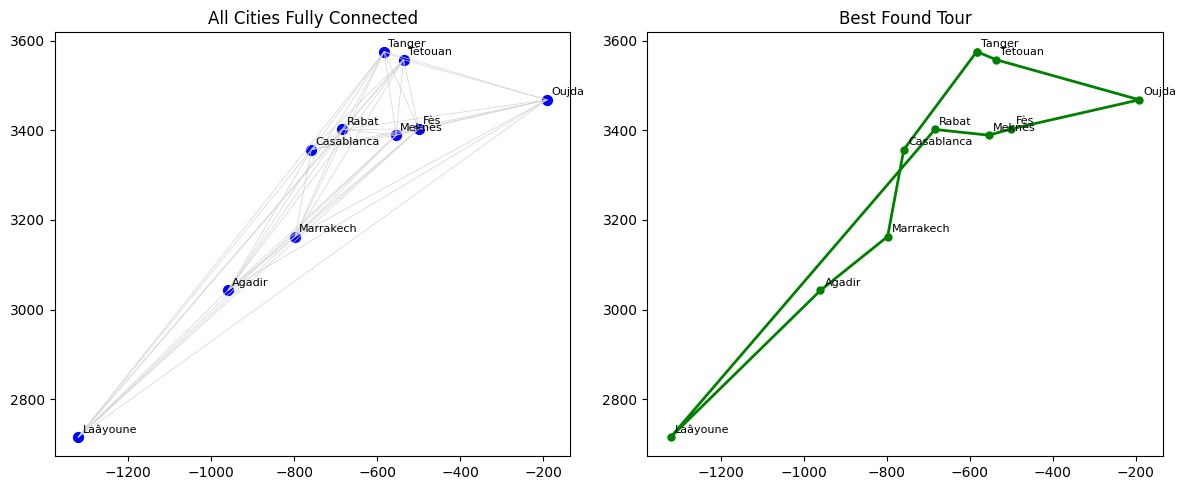

In [7]:
def optimize_mceo(distance_matrix, n_averages=5, n_search_agents=10, max_iter=100, alpha=0.2, srf_range=(0.95, 1.05)):
    n_cities = distance_matrix.shape[0]
    srf_min, srf_max = srf_range
    averages, sigmas = initialize(n_cities, n_averages)
    best_tour, best_distance = None, float('inf')
    
    # Historique pour le graphique
    history = []
    best_history = []

    for iteration in range(max_iter):
        all_tours, all_distances = [], []

        for i, (avg, sigma) in enumerate(zip(averages, sigmas)):
            for _ in range(n_search_agents):
                perturbed = avg + np.random.normal(0, sigma, size=avg.shape)
                perturbed = np.maximum(perturbed, 0)
                np.fill_diagonal(perturbed, 0)
                row_sums = np.sum(perturbed, axis=1, keepdims=True)
                row_sums[row_sums == 0] = 1
                perturbed /= row_sums

                tour = sample_tour(perturbed)
                dist = calculate_distance(tour, distance_matrix)
                all_tours.append((i, tour, dist))
                all_distances.append(dist)

        sorted_indices = np.argsort(all_distances)
        sorted_tours = [all_tours[i] for i in sorted_indices]

        # Mise à jour de l'historique
        current_best = all_distances[sorted_indices[0]]
        history.append(current_best)
        if current_best < best_distance:
            best_distance = current_best
            best_tour = sorted_tours[0][1]
            print(f"Iteration {iteration + 1}, Best Distance: {best_distance:.2f} km")
        best_history.append(best_distance)

        # [Le reste de votre fonction reste inchangé...]

    return best_tour, best_distance, history, best_history


if __name__ == "__main__":
    np.random.seed(42)
    distance_matrix = compute_distance_matrix(cities)
    coords = get_city_coordinates_3d(cities)
    city_names = [name for name, _, _ in cities]

    best_tour, best_distance, history, best_history = optimize_mceo(distance_matrix, max_iter=100)

    print("\n🏁 Meilleur chemin trouvé :")
    for i in best_tour:
        print(f"- {city_names[i]}")
    print(f"🔁 Distance totale : {best_distance:.2f} km")

    # Graphique de convergence
    plt.figure(figsize=(10, 6))
    plt.plot(history, 'b-', alpha=0.3, label='Meilleur de chaque itération')
    plt.plot(best_history, 'r-', linewidth=2, label='Meilleur global')
    plt.xlabel('Itération')
    plt.ylabel('Distance (km)')
    plt.title('Convergence de l\'algorithme MCEO')
    plt.legend()
    plt.grid(True)
    plt.show()

    plot_tours(coords, best_tour, city_names)

## Version Finale

Démarrage de l'optimisation...
Iteration 1: Current Best = 3444.77 km, Global Best = 3444.77 km
Iteration 2: Current Best = 3382.05 km, Global Best = 3382.05 km
Iteration 3: Current Best = 3226.50 km, Global Best = 3226.50 km
Iteration 4: Current Best = 3226.50 km, Global Best = 3226.50 km
Iteration 5: Current Best = 3137.00 km, Global Best = 3137.00 km
Iteration 6: Current Best = 3137.00 km, Global Best = 3137.00 km
Iteration 7: Current Best = 3137.00 km, Global Best = 3137.00 km
Iteration 8: Current Best = 3137.00 km, Global Best = 3137.00 km
Iteration 9: Current Best = 3137.00 km, Global Best = 3137.00 km
Iteration 10: Current Best = 3137.00 km, Global Best = 3137.00 km
Iteration 11: Current Best = 3137.00 km, Global Best = 3137.00 km
Iteration 12: Current Best = 3137.00 km, Global Best = 3137.00 km
Iteration 13: Current Best = 3137.00 km, Global Best = 3137.00 km
Iteration 14: Current Best = 3137.00 km, Global Best = 3137.00 km
Iteration 15: Current Best = 3137.00 km, Global Best =

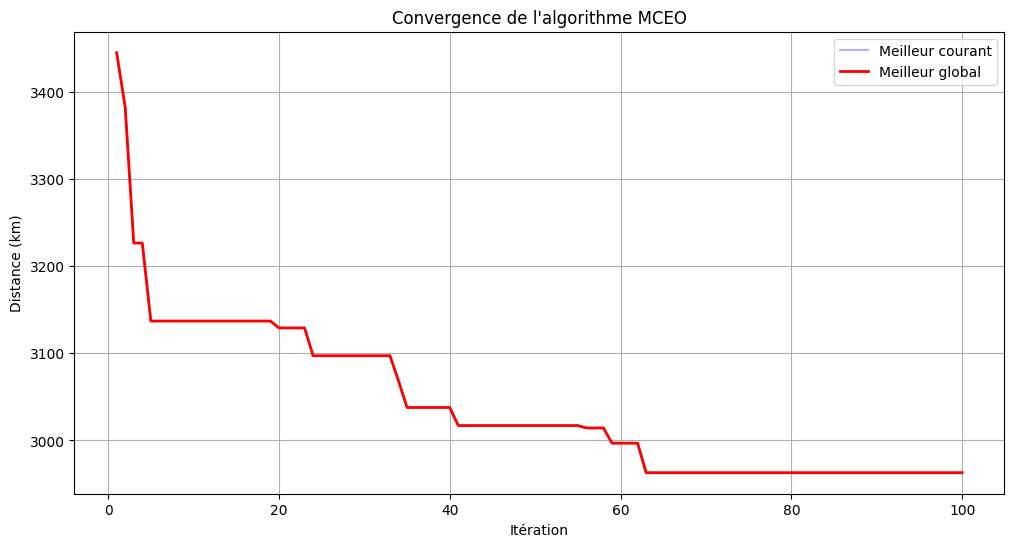

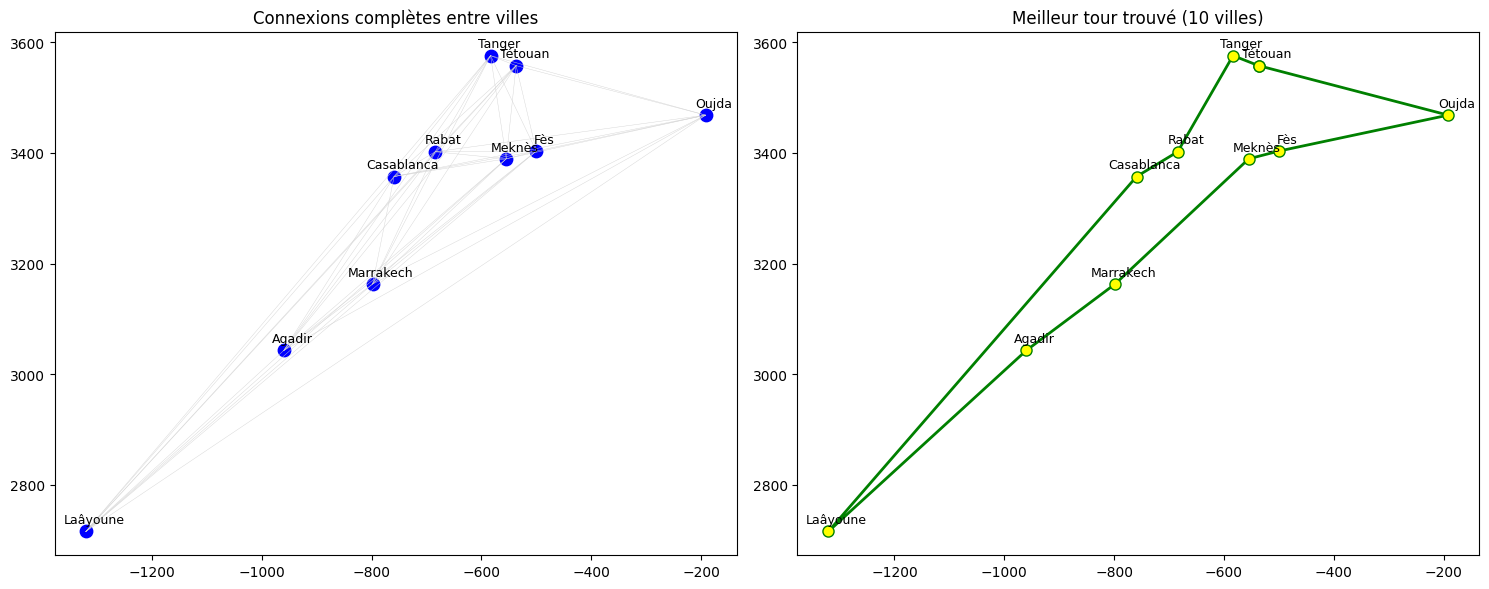

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# --- Données réelles : villes marocaines ---
cities = [
    ("Tanger", 35.7595, -5.8339),
    ("Tétouan", 35.5785, -5.3684),
    ("Fès", 34.0331, -5.0003),
    ("Rabat", 34.0209, -6.8417),
    ("Casablanca", 33.5731, -7.5898),
    ("Marrakech", 31.6295, -7.9811),
    ("Agadir", 30.4278, -9.5981),
    ("Oujda", 34.6833, -1.9167),
    ("Meknès", 33.8935, -5.5473),
    ("Laâyoune", 27.1536, -13.2033)
]

# --- Haversine ---
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def compute_distance_matrix(cities):
    n = len(cities)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i][j] = haversine_distance(
                    cities[i][1], cities[i][2],
                    cities[j][1], cities[j][2]
                )
    return dist_matrix

def get_city_coordinates_3d(cities):
    return np.array([[lon * 100, lat * 100, 0] for (_, lat, lon) in cities])

# --- MCEO TSP Core ---
def initialize(n_cities, n_averages):
    averages, sigmas = [], []
    for _ in range(n_averages):
        prob_matrix = np.ones((n_cities, n_cities)) / (n_cities - 1)
        np.fill_diagonal(prob_matrix, 0)
        averages.append(prob_matrix)
        sigmas.append(0.5 * (1.0 / n_averages))  # Reduced initial sigma
    return averages, sigmas

def sample_tour(prob_matrix):
    n_cities = prob_matrix.shape[0]
    tour, visited = [], set()
    current = random.randint(0, n_cities - 1)
    tour.append(current)
    visited.add(current)

    while len(tour) < n_cities:
        probs = prob_matrix[current].copy()
        for v in visited:
            probs[v] = 0
        if probs.sum() == 0:
            next_city = random.choice([c for c in range(n_cities) if c not in visited])
        else:
            probs /= probs.sum()
            next_city = np.random.choice(range(n_cities), p=probs)
        tour.append(next_city)
        visited.add(next_city)
        current = next_city

    return tour

def calculate_distance(tour, distance_matrix):
    return sum(distance_matrix[tour[i], tour[(i + 1) % len(tour)]] for i in range(len(tour)))

def update_prob_matrix(tours, n_cities):
    prob_matrix = np.zeros((n_cities, n_cities))
    for tour in tours:
        for i in range(len(tour)):
            u, v = tour[i], tour[(i + 1) % len(tour)]
            prob_matrix[u, v] += 1
            prob_matrix[v, u] += 1
    row_sums = prob_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    prob_matrix /= row_sums
    np.fill_diagonal(prob_matrix, 0)
    return prob_matrix

def optimize_mceo(distance_matrix, n_averages=5, n_search_agents=20, max_iter=100, alpha=0.2, srf_range=(0.9, 1.1)):
    n_cities = distance_matrix.shape[0]
    srf_min, srf_max = srf_range
    averages, sigmas = initialize(n_cities, n_averages)
    best_tour, best_distance = None, float('inf')
    
    # Historique de convergence
    history = {'iteration': [], 'current_best': [], 'global_best': []}

    for iteration in range(max_iter):
        all_tours, all_distances = [], []

        for i, (avg, sigma) in enumerate(zip(averages, sigmas)):
            for _ in range(n_search_agents):
                # Perturbation plus contrôlée
                perturbed = avg + 0.3 * np.random.normal(0, sigma, size=avg.shape)
                perturbed = np.maximum(perturbed, 0)
                np.fill_diagonal(perturbed, 0)
                row_sums = np.sum(perturbed, axis=1, keepdims=True)
                row_sums[row_sums == 0] = 1
                perturbed /= row_sums

                tour = sample_tour(perturbed)
                dist = calculate_distance(tour, distance_matrix)
                all_tours.append((i, tour, dist))
                all_distances.append(dist)

        sorted_indices = np.argsort(all_distances)
        sorted_tours = [all_tours[i] for i in sorted_indices]
        current_best_dist = all_distances[sorted_indices[0]]

        # Mise à jour de l'historique
        history['iteration'].append(iteration+1)
        history['current_best'].append(current_best_dist)
        if current_best_dist < best_distance:
            best_distance = current_best_dist
            best_tour = sorted_tours[0][1]
        history['global_best'].append(best_distance)

        print(f"Iteration {iteration + 1}: Current Best = {current_best_dist:.2f} km, Global Best = {best_distance:.2f} km")

        # Mise à jour des probabilités
        n_keep = int(n_averages * (1 - alpha))
        top_performers = sorted_tours[:n_keep * n_search_agents]
        avg_groups = {}
        for avg_idx, tour, dist in top_performers:
            if avg_idx not in avg_groups or dist < avg_groups[avg_idx][1]:
                avg_groups[avg_idx] = (tour, dist)

        new_averages = [update_prob_matrix([tour], n_cities) for tour, _ in avg_groups.values()]
        for _ in range(n_averages - len(new_averages)):
            prob_matrix = np.ones((n_cities, n_cities)) / (n_cities - 1)
            np.fill_diagonal(prob_matrix, 0)
            new_averages.append(prob_matrix)

        # Mise à jour plus douce des sigmas
        srf_values = np.linspace(srf_min, srf_max, n_averages)
        new_sigmas = []
        for i in range(n_averages):
            rank_factor = (i + 1) / n_averages
            sigma = 0.3 * (rank_factor ** 2) * (1.0 / n_cities)  # Réduction du sigma
            sigma *= srf_values[i]
            new_sigmas.append(sigma)

        averages, sigmas = new_averages, new_sigmas

        # Critère de convergence plus strict
        if iteration > 20 and np.std(all_distances[:n_averages * n_search_agents]) < 0.1:
            print(f"Convergence atteinte à l'itération {iteration + 1}")
            break

    return best_tour, best_distance, history

# --- Visualisation ---
def plot_convergence(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history['iteration'], history['current_best'], 'b-', alpha=0.3, label='Meilleur courant')
    plt.plot(history['iteration'], history['global_best'], 'r-', linewidth=2, label='Meilleur global')
    plt.xlabel('Itération')
    plt.ylabel('Distance (km)')
    plt.title('Convergence de l\'algorithme MCEO')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_tours(coords, best_tour, city_names):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Avant optimisation
    axes[0].set_title("Connexions complètes entre villes")
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            axes[0].plot([coords[i][0], coords[j][0]], [coords[i][1], coords[j][1]], color='lightgray', linewidth=0.3)
    axes[0].scatter(coords[:, 0], coords[:, 1], color='blue', s=80)
    for idx, (x, y, _) in enumerate(coords):
        axes[0].text(x + 15, y + 15, city_names[idx], fontsize=9, ha='center')

    # Après optimisation
    axes[1].set_title(f"Meilleur tour trouvé ({len(best_tour)} villes)")
    tour_coords = coords[np.append(best_tour, best_tour[0])]
    axes[1].plot(tour_coords[:, 0], tour_coords[:, 1], 'o-', color='green', 
                linewidth=2, markersize=8, markerfacecolor='yellow')
    for idx in best_tour:
        x, y, _ = coords[idx]
        axes[1].text(x + 15, y + 15, city_names[idx], fontsize=9, ha='center')

    plt.tight_layout()
    plt.show()

# --- Main ---
if __name__ == "__main__":
    # Double graine aléatoire pour plus de reproductibilité
    np.random.seed(42)
    random.seed(42)
    
    distance_matrix = compute_distance_matrix(cities)
    coords = get_city_coordinates_3d(cities)
    city_names = [name for name, _, _ in cities]

    print("Démarrage de l'optimisation...")
    best_tour, best_distance, history = optimize_mceo(
        distance_matrix, 
        n_averages=7,       # Augmenté pour plus de stabilité
        n_search_agents=25,  # Augmenté pour meilleure exploration
        max_iter=100,
        alpha=0.15          # Réduit pour conserver plus de bonnes solutions
    )

    print("\n🔥 Résultats finaux 🔥")
    print("🏁 Meilleur chemin trouvé :")
    for i, city_idx in enumerate(best_tour):
        print(f"{i+1}. {city_names[city_idx]}")
    print(f"📏 Distance totale : {best_distance:.2f} km")

    plot_convergence(history)
    plot_tours(coords, best_tour, city_names)

### afficher que les itérations avec des améliorations

Démarrage de l'optimisation...
Iteration   1: Current = 3444.77 km | Global = 3444.77 km *
Iteration   2: Current = 3382.05 km | Global = 3382.05 km *
Iteration   3: Current = 3226.50 km | Global = 3226.50 km *
Iteration   5: Current = 3137.00 km | Global = 3137.00 km *
Iteration  20: Current = 3129.12 km | Global = 3129.12 km *
Iteration  24: Current = 3097.22 km | Global = 3097.22 km *
Iteration  34: Current = 3068.47 km | Global = 3068.47 km *
Iteration  35: Current = 3037.88 km | Global = 3037.88 km *
Iteration  41: Current = 3017.13 km | Global = 3017.13 km *
Iteration  56: Current = 3014.38 km | Global = 3014.38 km *
Iteration  59: Current = 2996.92 km | Global = 2996.92 km *
Iteration  63: Current = 2963.04 km | Global = 2963.04 km *
Iteration 100: Current = 2963.04 km | Global = 2963.04 km 

🔥 Résultats finaux 🔥
🏁 Meilleur chemin trouvé :
1. Tétouan
2. Tanger
3. Rabat
4. Casablanca
5. Laâyoune
6. Agadir
7. Marrakech
8. Meknès
9. Fès
10. Oujda
📏 Distance totale : 2963.04 km


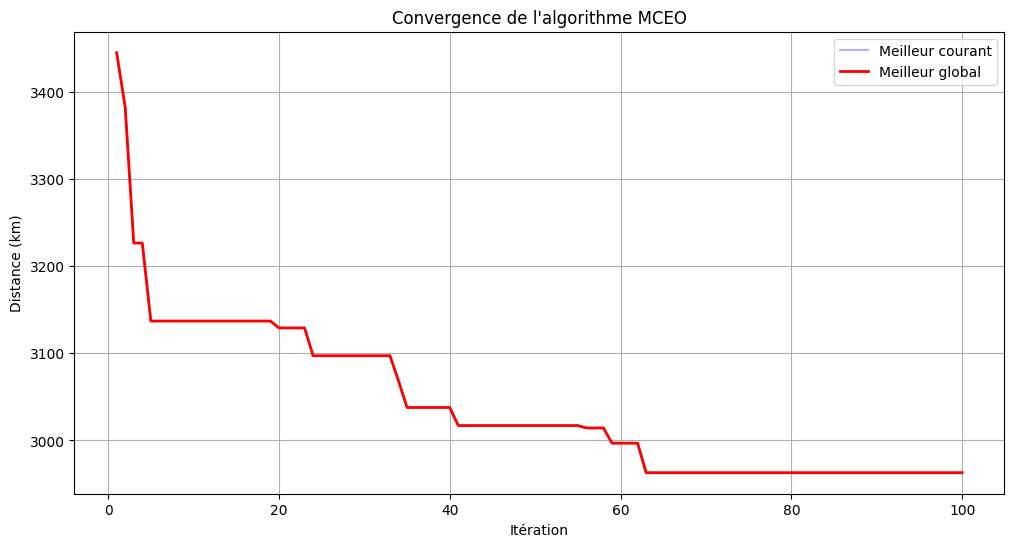

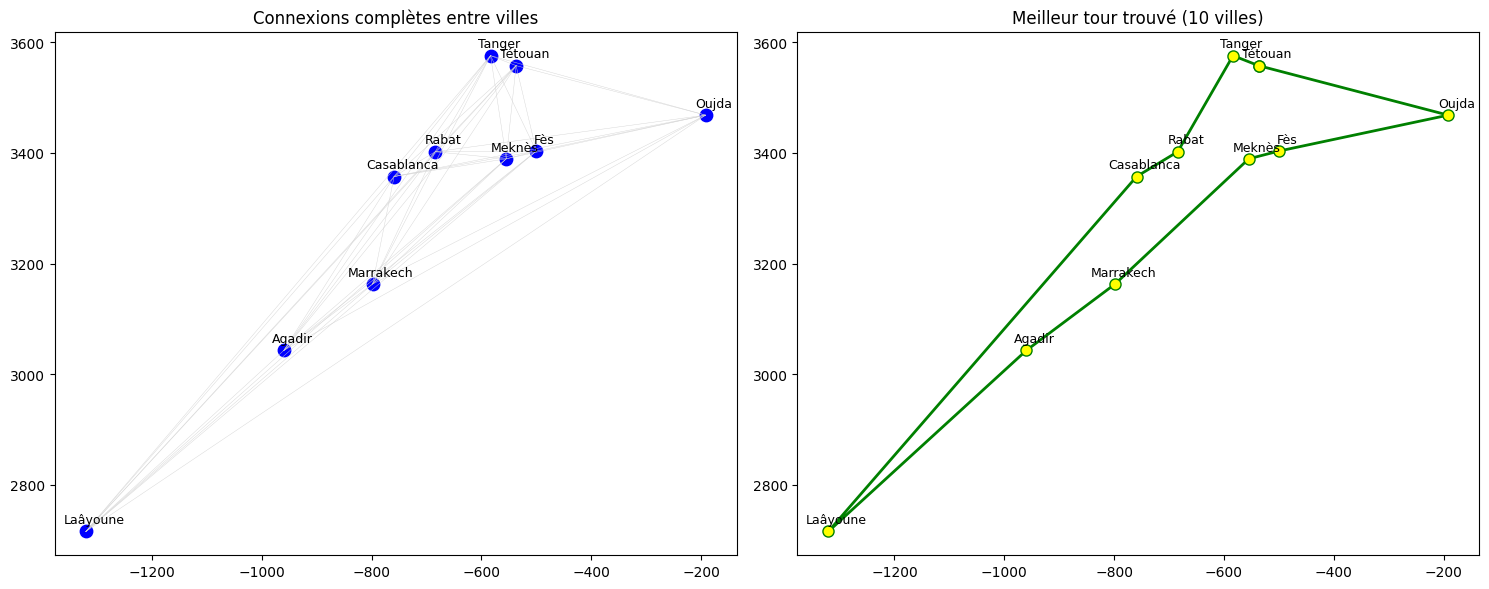

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# --- Données réelles : villes marocaines ---
cities = [
    ("Tanger", 35.7595, -5.8339),
    ("Tétouan", 35.5785, -5.3684),
    ("Fès", 34.0331, -5.0003),
    ("Rabat", 34.0209, -6.8417),
    ("Casablanca", 33.5731, -7.5898),
    ("Marrakech", 31.6295, -7.9811),
    ("Agadir", 30.4278, -9.5981),
    ("Oujda", 34.6833, -1.9167),
    ("Meknès", 33.8935, -5.5473),
    ("Laâyoune", 27.1536, -13.2033)
]

# --- Haversine ---
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def compute_distance_matrix(cities):
    n = len(cities)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dist_matrix[i][j] = haversine_distance(
                    cities[i][1], cities[i][2],
                    cities[j][1], cities[j][2]
                )
    return dist_matrix

def get_city_coordinates_3d(cities):
    return np.array([[lon * 100, lat * 100, 0] for (_, lat, lon) in cities])

# --- MCEO TSP Core ---
def initialize(n_cities, n_averages):
    averages, sigmas = [], []
    for _ in range(n_averages):
        prob_matrix = np.ones((n_cities, n_cities)) / (n_cities - 1)
        np.fill_diagonal(prob_matrix, 0)
        averages.append(prob_matrix)
        sigmas.append(0.5 * (1.0 / n_averages))  # Reduced initial sigma
    return averages, sigmas

def sample_tour(prob_matrix):
    n_cities = prob_matrix.shape[0]
    tour, visited = [], set()
    current = random.randint(0, n_cities - 1)
    tour.append(current)
    visited.add(current)

    while len(tour) < n_cities:
        probs = prob_matrix[current].copy()
        for v in visited:
            probs[v] = 0
        if probs.sum() == 0:
            next_city = random.choice([c for c in range(n_cities) if c not in visited])
        else:
            probs /= probs.sum()
            next_city = np.random.choice(range(n_cities), p=probs)
        tour.append(next_city)
        visited.add(next_city)
        current = next_city

    return tour

def calculate_distance(tour, distance_matrix):
    return sum(distance_matrix[tour[i], tour[(i + 1) % len(tour)]] for i in range(len(tour)))

def update_prob_matrix(tours, n_cities):
    prob_matrix = np.zeros((n_cities, n_cities))
    for tour in tours:
        for i in range(len(tour)):
            u, v = tour[i], tour[(i + 1) % len(tour)]
            prob_matrix[u, v] += 1
            prob_matrix[v, u] += 1
    row_sums = prob_matrix.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    prob_matrix /= row_sums
    np.fill_diagonal(prob_matrix, 0)
    return prob_matrix

def optimize_mceo(distance_matrix, n_averages=5, n_search_agents=20, max_iter=100, alpha=0.2, srf_range=(0.9, 1.1)):
    n_cities = distance_matrix.shape[0]
    srf_min, srf_max = srf_range
    averages, sigmas = initialize(n_cities, n_averages)
    best_tour, best_distance = None, float('inf')
    last_printed_dist = float('inf')
    last_printed_global = float('inf')
    
    # Historique de convergence
    history = {'iteration': [], 'current_best': [], 'global_best': []}

    for iteration in range(max_iter):
        all_tours, all_distances = [], []

        # Phase d'échantillonnage
        for i, (avg, sigma) in enumerate(zip(averages, sigmas)):
            for _ in range(n_search_agents):
                perturbed = avg + 0.3 * np.random.normal(0, sigma, size=avg.shape)
                perturbed = np.maximum(perturbed, 0)
                np.fill_diagonal(perturbed, 0)
                row_sums = np.sum(perturbed, axis=1, keepdims=True)
                row_sums[row_sums == 0] = 1
                perturbed /= row_sums

                tour = sample_tour(perturbed)
                dist = calculate_distance(tour, distance_matrix)
                all_tours.append((i, tour, dist))
                all_distances.append(dist)

        # Tri des solutions
        sorted_indices = np.argsort(all_distances)
        sorted_tours = [all_tours[i] for i in sorted_indices]
        current_best_dist = all_distances[sorted_indices[0]]

        # Mise à jour de l'historique
        history['iteration'].append(iteration+1)
        history['current_best'].append(current_best_dist)
        
        improved = False
        if current_best_dist < best_distance:
            best_distance = current_best_dist
            best_tour = sorted_tours[0][1]
            improved = True
        
        history['global_best'].append(best_distance)

        # Conditions d'affichage
        print_iteration = False
        current_diff = abs(current_best_dist - last_printed_dist)
        global_diff = abs(best_distance - last_printed_global)
        
        # Toujours afficher la première et dernière itération
        if iteration == 0 or iteration == max_iter - 1:
            print_iteration = True
        # Afficher les améliorations significatives
        elif improved and global_diff > 0.1:
            print_iteration = True
        # Afficher occasionnellement même sans amélioration
        elif iteration % 10 == 0 and current_diff > 0.5:
            print_iteration = True

        if print_iteration:
            print(f"Iteration {iteration + 1:3d}: Current = {current_best_dist:7.2f} km | Global = {best_distance:7.2f} km {'*' if improved else ''}")
            last_printed_dist = current_best_dist
            last_printed_global = best_distance

        # Sélection des meilleures solutions
        n_keep = int(n_averages * (1 - alpha))
        top_performers = sorted_tours[:n_keep * n_search_agents]
        avg_groups = {}
        for avg_idx, tour, dist in top_performers:
            if avg_idx not in avg_groups or dist < avg_groups[avg_idx][1]:
                avg_groups[avg_idx] = (tour, dist)

        # Mise à jour des matrices de probabilité
        new_averages = [update_prob_matrix([tour], n_cities) for tour, _ in avg_groups.values()]
        for _ in range(n_averages - len(new_averages)):
            prob_matrix = np.ones((n_cities, n_cities)) / (n_cities - 1)
            np.fill_diagonal(prob_matrix, 0)
            new_averages.append(prob_matrix)

        # Adaptation dynamique des sigmas
        srf_values = np.linspace(srf_min, srf_max, n_averages)
        new_sigmas = []
        for i in range(n_averages):
            rank_factor = (i + 1) / n_averages
            sigma = 0.3 * (rank_factor ** 2) * (1.0 / n_cities)
            sigma *= srf_values[i]
            new_sigmas.append(sigma)

        averages, sigmas = new_averages, new_sigmas

        # Critère de convergence
        if iteration > 20 and np.std(all_distances[:n_averages * n_search_agents]) < 0.1:
            print(f"\nConvergence atteinte à l'itération {iteration + 1}")
            break

    return best_tour, best_distance, history

# --- Visualisation ---
def plot_convergence(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history['iteration'], history['current_best'], 'b-', alpha=0.3, label='Meilleur courant')
    plt.plot(history['iteration'], history['global_best'], 'r-', linewidth=2, label='Meilleur global')
    plt.xlabel('Itération')
    plt.ylabel('Distance (km)')
    plt.title('Convergence de l\'algorithme MCEO')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_tours(coords, best_tour, city_names):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Avant optimisation
    axes[0].set_title("Connexions complètes entre villes")
    for i in range(len(coords)):
        for j in range(i + 1, len(coords)):
            axes[0].plot([coords[i][0], coords[j][0]], [coords[i][1], coords[j][1]], color='lightgray', linewidth=0.3)
    axes[0].scatter(coords[:, 0], coords[:, 1], color='blue', s=80)
    for idx, (x, y, _) in enumerate(coords):
        axes[0].text(x + 15, y + 15, city_names[idx], fontsize=9, ha='center')

    # Après optimisation
    axes[1].set_title(f"Meilleur tour trouvé ({len(best_tour)} villes)")
    tour_coords = coords[np.append(best_tour, best_tour[0])]
    axes[1].plot(tour_coords[:, 0], tour_coords[:, 1], 'o-', color='green', 
                linewidth=2, markersize=8, markerfacecolor='yellow')
    for idx in best_tour:
        x, y, _ = coords[idx]
        axes[1].text(x + 15, y + 15, city_names[idx], fontsize=9, ha='center')

    plt.tight_layout()
    plt.show()

# --- Main ---
if __name__ == "__main__":
    # Double graine aléatoire pour plus de reproductibilité
    np.random.seed(42)
    random.seed(42)
    
    distance_matrix = compute_distance_matrix(cities)
    coords = get_city_coordinates_3d(cities)
    city_names = [name for name, _, _ in cities]

    print("Démarrage de l'optimisation...")
    best_tour, best_distance, history = optimize_mceo(
        distance_matrix, 
        n_averages=7,       # Augmenté pour plus de stabilité
        n_search_agents=25,  # Augmenté pour meilleure exploration
        max_iter=100,
        alpha=0.15          # Réduit pour conserver plus de bonnes solutions
    )

    print("\n🔥 Résultats finaux 🔥")
    print("🏁 Meilleur chemin trouvé :")
    for i, city_idx in enumerate(best_tour):
        print(f"{i+1}. {city_names[city_idx]}")
    print(f"📏 Distance totale : {best_distance:.2f} km")

    plot_convergence(history)
    plot_tours(coords, best_tour, city_names)